In [1]:
# Copied from 240808_SigClipKT_selectCO.ipynb

from multiprocessing import Pool
import multiprocessing as mp
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join
from astropy.wcs import WCS
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import spearmanr

from dustmaps.vergely2022 import Vergely2022Query
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pickle 
import sys
import os
import tqdm
import datetime

import emcee
import corner

import h5py
import multiprocessing as mp

data_dir = '/uufs/chpc.utah.edu/common/home/astro/zasowski/mcbride/'

/uufs/astro.utah.edu/common/home/u1371365/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import globalvars
dust_data = globalvars.DustData()

In [3]:
print(matplotlib.__version__)

3.9.0


In [4]:
map_fname = '/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/edenhofer_out.h5'

with h5py.File(map_fname, 'r') as f:
    edenhofer = np.array(f['data'])
    dust_data.intake_map(edenhofer)

/tmp/ipykernel_3935544/2315330892.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  edenhofer = np.array(f['data'])


In [5]:
print(dust_data.l[0, 1, 0] - dust_data.l[0, 0, 0])
print(dust_data.b[1, 0, 0] - dust_data.b[0, 0, 0])

0.02252816020023829
0.022528160200248948


In [6]:
CA_meta = Table(fits.open(data_dir + '/data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

CA_meta_full = CA_meta.copy()

with open('/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)

# added 02.01
data_criteria = (((CA_meta['SNR'] > 80) & (CA_meta['TEFF'] > 5000)) | (CA_meta['SNR'] > 150)) & (CA_meta['ASPCAP_CHI2_1'] > 1) & (CA_meta['ASPCAP_CHI2_1'] < 5)
print(np.sum(data_criteria))
CA_meta= CA_meta[data_criteria]

1010


(154.0, 172.0, -17.0, 1.0)


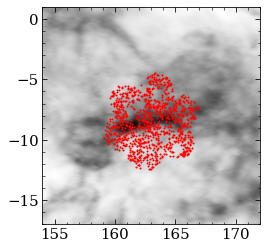

In [7]:
fig, ax = plt.subplots(
)
dust_extent = (np.min(dust_data.l), np.max(dust_data.l), np.min(dust_data.b), np.max(dust_data.b))
ax.imshow(np.sum(dust_data.dustmap, axis = 2), extent = dust_extent, origin = 'lower', cmap = 'binary')
ax.scatter(CA_meta['GLON'], CA_meta['GLAT'], c = 'r', s = 1)
print(dust_extent)

In [8]:
from specfns import get_wavs, resample_interp, dopplershift, lambda0, sigma0
from filehandling import get_ca_res, get_madgics_res, get_medres
from spacefns_v2 import select_stars, find_nearest, find_radius, differentialAmplitude
from MCMCfns import logprob_2
from sightline import Sightline
import time

In [ ]:
CA_meta = Table(fits.open(data_dir + '/data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
# starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
# starhorse = Table.read(starhorsepath, hdu = 1)
# starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

# CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

CA_meta_full = CA_meta.copy()

with open('/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)

# added 02.01
data_criteria = (((CA_meta['SNR'] > 80) & (CA_meta['TEFF'] > 5000)) | (CA_meta['SNR'] > 150)) & (CA_meta['ASPCAP_CHI2_1'] > 1) & (CA_meta['ASPCAP_CHI2_1'] < 5)
print(np.sum(data_criteria))
CA_meta= CA_meta[data_criteria]

1010


In [10]:
print(CA_meta['APOGEE_ID'][16])

2M04070371+3629331


In [11]:
lambda0 = 15272.42
from specfns import get_wavs

wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
wavs_window = wavs[window]

In [ ]:
line = lambda x, m: m*x + 0
from scipy.optimize import curve_fit
popt, pcov = curve_fit(line, tab['DIST'], tab['DIB_EQW'], nan_policy = 'omit')

In [ ]:
ds = 1 # x downsampled
rad = 2

sample_dim_l = np.linspace(159, 167, int(8 / (ds * rad)))
sample_dim_b = np.linspace(-12.5 , -4.5, int(8 / (ds * rad)))
sample_grid_l, sample_grid_b = np.meshgrid(sample_dim_l, sample_dim_b)
grid_map_inds = np.array([find_nearest(sample_grid_l.flatten()[i], sample_grid_b.flatten()[i]) for i in range(len(sample_grid_l.flatten()))]).T
grid_map = np.nansum(np.copy(edenhofer[grid_map_inds[1], grid_map_inds[0], :]).reshape(*sample_grid_l.shape, -1), axis = 2)
grid_Nstar = np.array([np.nansum((np.abs((sample_grid_l.flatten()[i] - CA_meta['GLON'])) <= rad) & 
            (np.abs((sample_grid_b.flatten()[i] - CA_meta['GLAT'])) <= rad)) for i in range(len(sample_grid_l.flatten()))]).reshape(*sample_grid_l.shape)

filament_l = (159, 169)
filament_b = (-10, -6)

N_min = 25
radius_min = np.zeros(sample_grid_l.shape)
mgrid = np.mgrid[0:len(sample_dim_l), 0:len(sample_dim_b)]
for i in mgrid[0].flatten():
    for j in mgrid[1].flatten():
        radius_min[i, j] = find_radius(sample_grid_l[i, j], sample_grid_b[i, j], N_min, CA_meta)
        radius_min[i, j] = np.max([radius_min[i, j], rad])

radius_max = 0.4
print(np.nansum(radius_min < radius_max))


crit_filament = ((sample_grid_l > filament_l[0]) & (sample_grid_l < filament_l[1]) & 
                 (sample_grid_b > filament_b[0]) & (sample_grid_b < filament_b[1]) &
                 (grid_map > 2.2) & (radius_min < 0.5)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

crit_background =  (((sample_grid_l <= filament_l[0]) | (sample_grid_l >= filament_l[1]) |
                 (sample_grid_b <= filament_b[0]) | (sample_grid_b >= filament_b[1])) &
                 (grid_map <= 1.5) & (radius_min < radius_max)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

# crit_coverage = (np.sum() => 1 & )

N_filament = np.sum(crit_filament)
N_background = np.sum(crit_background)
print(np.sum(crit_filament))
print(np.sum(crit_background))
l_fil, b_fil, AV_fil = (sample_grid_l[crit_filament].flatten(), sample_grid_b[crit_filament].flatten(),
                        grid_map[crit_filament].flatten())
l_off, b_off, AV_off = (sample_grid_l[crit_background].flatten(), sample_grid_b[crit_background].flatten(),
                        grid_map[crit_background].flatten())

l_sample, b_sample, AV_sample = (np.concatenate([l_fil, l_off]), np.concatenate([b_fil, b_off]),
                                  np.concatenate([AV_fil, AV_off]))
radius_min_fil = radius_min[crit_filament].flatten()
radius_min_off = radius_min[crit_background].flatten()
radius_sample = np.concatenate([radius_min_fil, radius_min_off])

# selected_inds = []
# for i in range(len(l_sample)):
#     l_center, b_center = l_sample[i], b_sample[i]
#     rad_i = radius_sample[i]
#     selection = select_stars(CA_meta, l_center, b_center, radius = rad_i)
#     # print(len(selection))
#     selected_inds.append(selection)

0
0
0


In [34]:

selected_inds = []
N_min_vals = [15, 20, 35, 50]
l_center, b_center = 165,-8.5
for N_min in N_min_vals:
    # N_min = 25
    radius_min = 0
    mgrid = np.mgrid[0:len(sample_dim_l), 0:len(sample_dim_b)]
    rad = find_radius(l_center, b_center, N_min, CA_meta)
    rad_sel = np.max([radius_min, rad])
    selection = select_stars(CA_meta, l_center, b_center, radius = rad_sel)
    # print(len(selection))
    selected_inds.append(selection)

In [35]:
selection.shape

(50,)

In [36]:
dibfn = lambda x, mu, sigma, a: 1-a * np.exp(-0.5 * (x - mu)**2 / sigma**2)
def sigma_clip_mask(y, x = wavs, k = 2.5):
    y_over_gauss = None

    try:
        gaussfit = curve_fit(dibfn, x[window], y[window].filled(np.nan), p0 = (15272, 1.2, 0.05), bounds = ([15269, 0.5, 0], [15275, 2, 0.15]), check_finite = False, nan_policy = 'omit')

    except:
        # gaussfit = ((15272, 1.2, 0.05),())
        print('fail')
        return None, None
    #     y_over_gauss = None
    #     gaussfit = ((15272, 1.2, 0.05),())
    #     # fit = dibfn(x, 15272.42, 1.2, 0.05)
    #     # y_over_gauss = y / fit
    #     print('POOR GAUSS FIT IN SIGMA CLIP')
    y_over_gauss = y / dibfn(x, *gaussfit[0])

    med = np.nanmedian(y_over_gauss[window])
    stdev = np.std(y_over_gauss[window], ddof = 1)
    mask = np.abs(y_over_gauss - med) > k * stdev
    mask = mask + np.roll(mask, -1) + np.roll(mask, -1)
    mask = mask.astype(bool)
    return mask, stdev

def sigmaClip(y, yerr,k=2.5):
    clip = True
    clip_iters = 0
    std = np.nanstd(y[window], ddof = 1)
    mask = np.zeros(y.shape).astype(bool)
    clip_success = True

    while clip:
        clip_mask, std_clipped = sigma_clip_mask(np.ma.array(y, mask = mask.copy()), k = k)
        if clip_mask is None:
            clip_success = False
            return mask, clip_success
        clip_mask = clip_mask.filled(False)

        if std - std_clipped  < 1e-4:
            clip = False


        else:
            clip_iters += 1
            std = std_clipped
            mask = mask + clip_mask

    return mask, clip_success

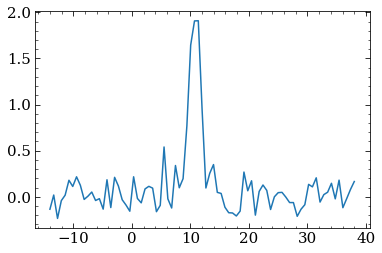

In [37]:
dataPath = '/uufs/chpc.utah.edu/common/home/astro/zasowski/mcbride/data/DHT21_Taurus_interp.fits'
hdulCO = fits.open(dataPath)

headerCO = hdulCO[0].header
dataCO = hdulCO[0].data
wcsCO = WCS(headerCO)

glon = headerCO['CRVAL2'] + headerCO['CDELT2'] * (np.arange(0, headerCO['NAXIS2'])- headerCO['CRPIX2'])
glat = headerCO['CRVAL3'] + headerCO['CDELT3'] * (np.arange(0, headerCO['NAXIS3'])- headerCO['CRPIX3'])
rvel = headerCO['CRVAL1'] + headerCO['CDELT1'] * (np.arange(0, headerCO['NAXIS1'])- headerCO['CRPIX1'])

l, b, v = np.meshgrid(glon, glat, rvel)
coord = SkyCoord(l * u.deg, b  * u.deg, radial_velocity = v * u.km/u.s, pm_l_cosb = 0 * u.deg/u.s,
                  pm_b = 0 * u.deg / u.s, distance = 500 * u.pc, frame = 'galacticlsr')

coord_icrs = coord.transform_to('icrs')

def get_CO_profile(l, b):
    coord_sel = SkyCoord(l = l * u.deg, b = b * u.deg, frame = 'galactic')
    pix_ind_l, pix_ind_b = wcsCO.world_to_pixel(0 * u.km/u.s, coord_sel)[1:]
    CO_profile = dataCO.T[:, int(pix_ind_l), int(pix_ind_b)]
    rvel = coord_icrs.T.radial_velocity[:, int(pix_ind_l), int(pix_ind_b)]
    return CO_profile, rvel
profile, rvel = get_CO_profile(165, -7)

plt.plot(rvel, profile)

In [38]:
def generateClippedResidual(aspcap, medres, apstar, rv, k = 3):
    spectrum = aspcap[1].data
    model = aspcap[3].data
    err = aspcap[2].data
    bitmask = apstar[3].data[0, :]

    if medres[1].data is None:
        medres_model = np.ones(spectrum.shape)
        medres_err =np.zeros(spectrum.shape)
    else:
        medres_model = np.array(medres[1].data)
        medres_err = np.array(medres[3].data)



    mask_digits = [0, 1, 2, 9, 12, 13] # 0 BADPIX, 1 CRPIX, 2 SATPIX, 9 PERSIST_HIGH, 12 SIG_SKYLINE, 13 SIG_TELLURIC
    mask = np.zeros(bitmask.shape)
    for digit in mask_digits:
        mask = mask + np.bitwise_and(bitmask.astype(int), 2**digit) 

    mask = mask.astype(bool)
    res_corr = spectrum / model / medres_model
    # print('res corr shape', res_corr.shape)
    uncertainty_corr = np.sqrt(err**2) #+ medres_err**2)

    sky_residuals = [(15268.1, 1),(15274.1, 1),(15275.9, 1)]
    manual_masks = np.zeros(len(wavs))
    for sky in sky_residuals:
        wl = sky[0]
        manual_masks[np.argmin(np.abs(wavs - wl))] = True
    manual_masks = manual_masks + np.roll(manual_masks, -1) + np.roll(manual_masks, 1)

    # mask_sigmaclip = np.zeros(len(wavs))


    maskSigClip, clip_success = sigmaClip(res_corr, uncertainty_corr, k = k)

    mask = mask + maskSigClip
    mask = mask.astype(bool)

    res_corr_ma = np.ma.array(res_corr, mask = mask)
    res_corr_filled = res_corr_ma.filled(np.nan)

    res_corr_resamp = resample_interp(res_corr_filled, rv)
    uncertainty_corr_resamp = resample_interp(uncertainty_corr, rv)

    sky_residuals = [(15268.1, 1),(15274.1, 1),(15275.9, 1)]
    manual_masks = np.zeros(len(wavs))
    for sky in sky_residuals:
        wl = sky[0]
        manual_masks[np.argmin(np.abs(wavs - wl))] = True
    manual_masks = manual_masks + np.roll(manual_masks, -1) + np.roll(manual_masks, 1)


    res_corr_resamp = np.ma.array(res_corr_resamp, mask = manual_masks)
    res_corr_resamp = res_corr_resamp.filled(np.nan)


    return res_corr_resamp, uncertainty_corr_resamp#, clip_success

In [39]:
print('test')

test


In [40]:
from spacefns_v2 import dAV_dd_array
from residual_process import reprocess
from filehandling import getASPCAP, getapStar

class ForegroundModifiedSightline(Sightline):
    def __init__(self, stars, coords = None, dAVdd = None, dfore = 400, **kwargs):
        # self.all_stars = stars
        self.stars = stars[stars['DIST'] > dfore]
        dist = self.stars['DIST']

        self.make_fgbins()
        self.bin_inds = np.digitize(dist, self.bins)

        if coords is not None:
            self.l, self.b = coords
        else:
            self.l, self.b = (np.nanmean(self.stars['GLON']), np.nanmean(self.stars['GLAT']))
        
        self.rvelo = np.zeros(len(self.bins) - 1)
        self.get_DIBs(**kwargs)

        self.ndim = len(self.voxel_dAVdd)
        self.nsig = len(self.stars)

        self.test_init_signals = self.model_signals_fg(self.rvelo, self.dAVdd)
    
    def get_DIBs(self, MADGICS = False, alternative_data_processing = None, **kwargs):
        signals = np.zeros((len(self.stars), len(wavs_window)))
        signal_errs = np.zeros((len(self.stars), len(wavs_window)))
        dAVdd = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_all = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_mask =np.zeros((len(self.stars), len(self.bins)-1)).astype(bool)

        if alternative_data_processing is not None:
            # needs to take aspcap, medres, apstar, rv as arguments
            for i in range(len(self.stars)):
                star = self.stars[i]
                star_rv = star['VHELIO_AVG']
                aspcap = fits.open(getASPCAP(star))
                apstar = fits.open(getapStar(aspcap))
                medres = fits.open(get_medres(star['TEFF'], star['LOGG'], star['M_H']))
                sig, err = alternative_data_processing(aspcap, medres, apstar, star_rv)
                signals[i, :], signal_errs[i, :] = sig[window], err[window]

               
                l, b = star['GLON'], star['GLAT']
                dAVdd[i], dAVdd_all[i], dAVdd_mask[i] = dAV_dd_array(l, b, self.bins, star['DIST'], **kwargs)
        
        else:
            if MADGICS:
                signals_aspcap = np.zeros((len(self.stars), len(wavs_window)))
                signal_errs_aspcap = np.zeros((len(self.stars), len(wavs_window)))

            for i in range(len(self.stars)):
                star = self.stars[i]
                star_rv = star['VHELIO_AVG']
                res_hdul = fits.open(get_ca_res(star['FILE']))
                signals[i, :] = res_hdul[1].data[window]
                signal_errs[i, :] = res_hdul[2].data[window]
                reprocess_uncertainty = True
                if reprocess_uncertainty:
                    signal_errs[i, :] = self.reprocess_errs(res_hdul, star['VHELIO_AVG'])[window]
                reprocess_residual = True
                if reprocess_residual:
                    res_repr, err_repr = reprocess(res_hdul, star['VHELIO_AVG'])
                    signals[i, :] = res_repr[window]
                    signal_errs[i, :] = err_repr[window]
                l, b = star['GLON'], star['GLAT']
                dAVdd[i], dAVdd_all[i], dAVdd_mask[i] = dAV_dd_array(l, b, self.bins, star['DIST'], **kwargs)

                if MADGICS:
                    signals_aspcap[i, :] = np.copy(signals[i, :])
                    signal_errs_aspcap[i, :] = np.copy(signal_errs[i, :])
                    res_hdul_m = fits.open(get_madgics_res(star['FILE']))
                    signals[i, :] = res_hdul_m[1].data[0, 125:][window]



        self.signals = signals
        self.signal_errs = signal_errs
        self.dAVdd = dAVdd
        self.voxel_dAVdd = np.nanmedian(dAVdd_all, axis = 0)
        self.voxel_dAVdd_std = np.nanstd(dAVdd_all, axis = 0, ddof = 1)
        self.dAVdd_mask = dAVdd_mask.astype(bool)
        # self.dAVdd_v = dAVdd_v
        if MADGICS:
            self.signals_aspcap = signals_aspcap
            self.signal_errs_aspcap = signal_errs_aspcap

    def make_fgbins(self, binsep = 10, dfore = 400, **kwargs):
        dmin = 0 # start bins at 0pc
        dist = self.stars['DIST']
        bins = np.sort(np.insert(np.delete(dist, np.where(dist <= dmin)[0]), [0,1], [dmin, dfore]))
        # print('BINS BEFORE THING', bins)
        i = 0
        while i >= 0:
            try:
                next_bin = np.min(bins[bins > bins[i]])
            except:
                print('broke:')
                print(bins[bins > bins[i]])
                print(len(self.stars))

            bins[i+1] = np.max([next_bin, bins[i] + binsep]) + 0.01
            if bins[i+1] >= np.max(dist):
                bins = bins[:i+2]
                i = -np.inf
            i = i+1
        
        self.bins = bins

    def model_signals_fg(self, rvelo, dAVdd=None, binsep = None):
        if dAVdd is None:
            dAVdd = self.dAVdd
        if binsep is None:
            binsep = self.bins[1:]-self.bins[:-1]
        signals = np.zeros((len(self.stars), len(wavs_window)))
        peak_wavelength = dopplershift(rvelo)
        wavs_grid = np.tile(wavs_window, (len(self.bins)-1, 1))
        voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
        amp = differentialAmplitude(dAVdd, binsep)

        def single_signal(amp, bindex):
            amp[bindex :] = 0 # THIS MIGHT NEED TO BE -1

            voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
            summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
            # continuum = lambda x, m, b : m * (x - lambda0) + b
            # cont = continuum(wavs_window, 0, b)
            return summed_DIB  + 1


        for i in range(len(self.stars)):
            star = self.stars[i]
            dAVdd_star = dAVdd[i, :]
            # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
            amp = differentialAmplitude(dAVdd_star, 1)

            bin_index = self.bin_inds[i]
            # signals[i, :] = single_signal(bin_index)
            signals[i, :] = single_signal(amp, bin_index)
        return signals


In [41]:
sightlines = []
for i in range(len(selected_inds)):
    sightlines.append(ForegroundModifiedSightline(CA_meta[selected_inds[i]], dustdata = dust_data, alternative_data_processing = generateClippedResidual))

/tmp/ipykernel_3414198/3305682505.py:22: RuntimeWarning: invalid value encountered in divide
  res_corr = spectrum / model / medres_model
/tmp/ipykernel_3414198/3305682505.py:22: RuntimeWarning: divide by zero encountered in divide
  res_corr = spectrum / model / medres_model


In [42]:
# sightlines = sightlines[ 15:30]

In [63]:
from MCMCfns import logprob_fg, Logprior_Foreground

# def logprob_2(p, sl, logprior = logprior_v, loglikely = loglikely_2, **kwargs): ## NEW AS OF 05.16LIke.
#     ndim = len(sl.voxel_dAVdd)
#     v = p[ :ndim]
#     av = p[ndim:].reshape(-1, ndim)
#     lp = logprior(v, **kwargs)
#     lp_davdd = logprior_davdd(av, AV_base = sl.dAVdd)
#     lp_davdd_reg = 0.0 # logprior_davdd_reg(av, sl, **kwargs)
#     lp_davdd_reg_group = 0.0. logprior_davdd_reg_group(av, sl)
#     if (not np.isfinite(lp)) | (not np.isfinite(lp_davdd)) | (not np.isfinite(lp_davdd_reg)):
#         return -np.inf
#     return lp + lp_davdd  + lp_davdd_reg + loglikely_2(v, av, sl = sl, **kwargs) + lp_davdd_reg_group # group term added 10.13


# def logprob_fg(p, sl, lp_fore = None, **kwargs):
#     ndim = len(sl.voxel_dAVdd)
    
#     lprob = logprob_2(p, sl, **kwargs)
#     v = p[ :ndim]
#     av = p[ndim:].reshape(-1, ndim) #what shape is dAVddd? 

#     ### Added 05.08 ###
#     lprior_av_min = logprior_davdd_min(av)
#     lprob = lprob + lprior_av_min

#     lp_fore_v = lp_fore.logprior_foreground_v(v, sl.bins[1:])
#     # lp_fore_av = lp_fore.logprior_foreground_av(av, sl.bins[1:])
#     return lprob + lp_fore_v #+ lp_fore_av


def MCMC_fg(sl, steps = 1000, nwalkers = 100, pool = None, filename = None):
    ndim = len(sl.voxel_dAVdd) 
    nstar = len(sl.stars)
    ndim_amp = int(ndim + ndim * nstar)

    if nwalkers < 2 * ndim_amp:
        nwalkers = 2 * ndim_amp + 5
        print('WARNING: nwalkers updated to', nwalkers)

    lp_foreground = Logprior_Foreground(sl.l, sl.b)

    
    if filename is not None:
        backend = emcee.backends.HDFBackend(filename)
        backend.reset(nwalkers, ndim_amp)
    else:
        backend = None
    # dAVdd_prior = sl.dAVdd[:]
    # dAVdd_prior[dAVdd_prior == 0] = np.nan 
    # dAVdd_prior_med = np.nanmedian(dAVdd_prior, axis = 1)
    # dAVdd_prior_std = np.nanstd(dAVdd_prior, axis = 1, ddof = 1)
    # gaussparams = (dAVdd_prior_med, dAVdd_prior_std)
    # print(gaussparams)

    # with Pool(15) as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_fg, 
                                    kwargs={'sl': sl, 'lp_fore': lp_foreground}, pool = pool, backend = backend) # OKAY SO I FORGOT TO CHANGE THIS, WAS LOGPROB_2
    # init = 12.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
    init = 10 *  (np.random.random((nwalkers, ndim_amp)) - 0.5)

    init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
    init[:, ndim:][(init[:, ndim:] <= 0.1)] = 0.11 + 0.05 * np.random.random(np.sum(init[:, ndim:]<= 0.1))
    init[:, ndim:] 
    print('NDIM:', ndim, 'NSTAR:', nstar, 'INITSHAPE:', init.shape)
    
    sampler.run_mcmc(init,  steps, progress = True, store = True);
    
    return sampler, ndim, ndim_amp

In [44]:
sl = sightlines[0]
ndim = len(sl.voxel_dAVdd) 
nstar = len(sl.stars)
ndim_amp = int(ndim + ndim * nstar)
lp_foreground = Logprior_Foreground(sl.l, sl.b)
# lp_foreground.logprior_foreground_v(10, 400)

In [45]:
init = 10 *  (np.random.random((500, ndim_amp)) - 0.5)
init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
init[:, ndim:][(init[:, ndim:] <= 0.1)] = 0.11 + 0.05 * np.random.random(np.sum(init[:, ndim:]<= 0.1))
print(logprob_fg(init[5, :], sl, lp_fore = lp_foreground,))

-38678.5228143675


In [47]:
sl.bins[1:].shape
sl.dAVdd.shape

(15, 14)

In [48]:
print('ndim', sl.ndim)
print('nsig', sl.nsig)
print('signals shape', sl.signals.shape)
print('dA(V)/dd shape', sl.dAVdd.shape)
print('dA(V)/dd shape in logprob fn', sl.dAVdd.flatten().reshape(-1, sl.ndim).shape)

ndim 14
nsig 15
signals shape (15, 95)
dA(V)/dd shape (15, 14)
dA(V)/dd shape in logprob fn (15, 14)


In [49]:
sl.dAVdd

array([[0.81396484, 0.00245285, 0.00538635, 0.01468658, 0.0670166 ,
        0.17822266, 0.29663086, 0.15490723, 0.08483887, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.84179688, 0.00260544, 0.00540924, 0.01531982, 0.07617188,
        0.20654297, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.82714844, 0.00259209, 0.00534821, 0.01502991, 0.07055664,
        0.19494629, 0.31030273, 0.15380859, 0.2355957 , 0.19506836,
        0.16101074, 0.5546875 , 0.10491943, 0.01568604],
       [0.96289062, 0.00176907, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.87304688, 0.00271606, 0.005867  , 0.01637268, 0.0803833 ,
        0.20507812, 0.32788086, 0.16174316, 0.25732422, 0.24414062,
        0.        , 0.        , 0.        , 0.        ],
       [0.78320312, 0.00237274, 0.0

In [50]:
import os
print(os.getcwd())

/uufs/astro.utah.edu/common/home/u1371365/nanoKT_v1


In [54]:
t0 = time.time()

In [ ]:
# sightlines = sightlines[2:]

In [64]:
stp = 1250

# sampler, ndim, ndim_amp = MCMC_scary(a, steps = stp, nwalkers = 500)
# sTHIsTThisterasdfdsfafsdfsdafampler1, ndim1, ndim_amp1 = MCMC(a1, steps = stp)
# sampler2, ndim2, ndim_amp2 = MCMC(a2, steps = stp)
# sampler3, ndim3, ndim_amp3 = MCMC(a3, steps = stp)

if True:
    today = str(datetime.date.today()).split('-')
    datelabel = today[1]+today[2]
    run_label = 'kt_' + datelabel + 'b'
else:
    # run_label = 'kt_0513a' # BEST ONE STILL
    # run_label = 'kt_0530a'
    # run_label = 'kt_0601a' # in sigclip_3 
    # run_label = 'kt_0531a' # in sigclip_3
    run_label = 'kt_240808a'


first_run = True
log_stats = True
save_individual = False

if first_run:

    if not os.path.exists(data_dir + 'modelfiles/RUNS/' + run_label):
        os.makedirs(data_dir + 'modelfiles/RUNS/' + run_label)
    directory = data_dir + 'modelfiles/RUNS/' + run_label
        
    with Pool(8) as pool:
        for i in range(len(sightlines)):
            # try:
            if True:
                sl_i = sightlines[i]
                time_start = time.time()
                smplr, ndm, ndm_amp = MCMC_fg(sl_i, steps = stp, nwalkers = 1000, pool = pool, filename = directory + '/sampler_' + str(i) + '.h5')
                # mid = time.time()
                # print('Time mid - start', mid - start) # beat 7:22
                # smplr_, ndim_ = MCMC_vonly(sl_i, smplr, steps = 1200, nwalkers = 100, pool = None)
                # end = time.time()
                # print('Time end - start:',(end - start)/60)
                
                sl_i.intake(smplr)
                time_stop = time.time()
                time_elapsed = time_stop - time_start
                time_elapsed_str = str(time_elapsed // 60) + 'm'+ str(round(time_elapsed % 60,4)) + 's'
                state = 'success'

                with open(directory + '/LOG.txt', mode = 'a') as log:
                    log.write('Run with {} stars'.format(len(sl_i.stars)) + ' | ' + time_elapsed_str + ' | ' + str(time_elapsed) +' | ' + state + '\n')
            # except Exception as e:
            #     print('Something went wrong')
            #     sl_i = None 
            #     state = 'fail'
            #     with open('RUNS_FG_SIGCLIP/' + run_label + '/FAILS.txt', mode = 'a') as fails:
            #         fails.write(str(e))
                
#             with open('/RUNS_H5/240604_SIGCLIP_3/' + run_label + '_LOG.txt', mode = 'r+') as log:
#                 logstring = time.asctime() + ' | ' + str(i) + ' | ' + state + '\n'
#                 log.write(logstring)
else: 
    directory = data_dir + 'modelfiles/RUNS/' + run_label



NDIM: 20 NSTAR: 33 INITSHAPE: (1365, 680)


100%|██████████| 1250/1250 [19:17<00:00,  1.08it/s]


NDIM: 22 NSTAR: 47 INITSHAPE: (2117, 1056)


 32%|███▏      | 404/1250 [09:42<20:19,  1.44s/it]


KeyboardInterrupt: 

In [65]:
name = run_label

# first_run = False

# if first_run:
#     # f = open('RUNS_H5/240531_SIGCLIP_3/sightlines_{}.pickle'.format(name),'wb')
#     f = open('RUNS_H5/240604_SIGCLIP_3/sightlines_{}.pickle'.format(name),'wb')

#     pickle.dump(sightlines, f )
#     f.close()
# # else:
#     # f = open('RUNS_FG_SIGCLIP/' + run_label + '/sightlines_{}.pickle'.format(name), 'rb')
# #     f = open('RUNS_H5/240604_SIGCLIP_3/sightlines_{}.pickle'.format(name),'wb')
# #     sightlines = pickle.load(f)

# #     f.close()

In [66]:
chains = []
probabilities = []
path= directory + '/sampler_' + str(0) + '.h5'
reader = emcee.backends.HDFBackend(path)
chains.append(reader.get_chain())
probabilities.append(reader.get_log_prob())

N 0
ndim 20
nstars 33
medians shape (680,)
med_velo shape (20,)
med_dAV_dd shape (33, 20)
order_inds [ 5 14 29 28 17 31 25 20  2 18 12  9  4 21  0 16 26 11 15 22 27  8  6  3
  7 19 10 23 24 30 32  1 13]
signal_recreated.shape (33, 95)
5
14
29
28
17
31
25
20
2
18
12
9
4
21
0
16
26
11
15
22
27
8
6
3
7
19
10
23
24
30
32
1
13


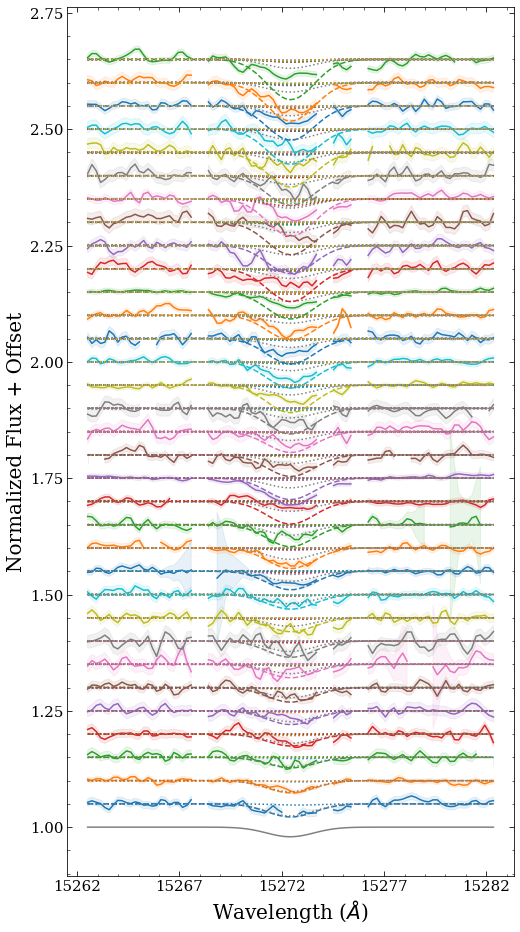

N 1


IndexError: list index out of range

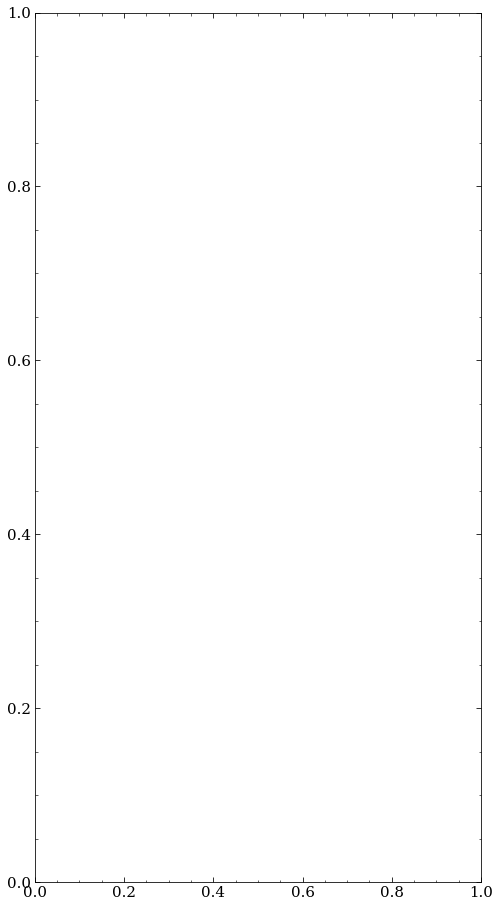

In [67]:
def model_signals_fg(rvelo, sl, dAVdd):
    # dAVdd = sl.dAVdd
    voxeldiffDIB = np.zeros((len(sl.stars), len(wavs_window)))
    unsummed_signals = np.zeros((len(sl.stars), len(sl.bins)-1,len(wavs_window)))
    # unsummed_signals = np.zeros((len(sl.bins)-1, len(sl.bins)-1,len(wavs_window)))

#     print(voxeldiffDIB.shape, unsummed_signals.shape, sl.dAVdd.shape)
    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(sl.bins) - 1, 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
    amp = differentialAmplitude(dAVdd, sl.bins[1:]-sl.bins[:-1])

    def single_signal(amp, bindex):

        amp[bindex:] = 0 # THIS MIGHT NEED TO BE -1
        # print(amp)

        voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        # continuum = lambda x, m, b : m * (x - lambda0) + b
        # cont = continuum(wavs_window, 0, b)
        return summed_DIB  + 1, voxel_DIB_scaled 

    fgdiffDIB = np.zeros((len(sl.stars), len(wavs_window)))
    

    for i in range(len(sl.stars)): # Iterate over each star in dAVdd array
#         print(dAVdd)
        dAVdd_bin = dAVdd[i, :] 

        amp = differentialAmplitude(dAVdd_bin, 1)

        bin_index = np.concatenate([sl.bin_inds]).astype(int)[i] # this only goes to 
        # signals[i, :] = single_signal(bin_index)
        voxeldiffDIB[i, :], unsummed_signals[i, :, :] = single_signal(amp, bin_index)
        fgdiffDIB[i, :], _ = single_signal(amp, 1)


    return voxeldiffDIB, unsummed_signals, fgdiffDIB

def plot_DIBS_fg(chain, sl, plot_objs = None, bestprob = False, lnprob = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs

    ndim = len(sl.voxel_dAVdd)
    print('ndim', ndim)
    nstars = len(sl.stars)
    print('nstars', nstars)

    samples = chain[:, :, :].reshape((-1, chain.shape[-1]))

    medians = np.nanmedian(samples[-100:, :], axis = 0)
    print('medians shape', medians.shape)

    ## NEW THING
    if bestprob:
        lp =lnprob
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = chain[w_ind, stp_ind, :]

    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
#     print(med_dAV_dd)
    print('med_velo shape', med_velo.shape)
    print('med_dAV_dd shape', med_dAV_dd.shape)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # order_inds = (np.array(np.argsort(sl.stars['DIST'])))
    print('order_inds', order_inds)

    signal_recreated, signal_recreated_unsummed, fg_dibs = model_signals_fg(med_velo, sl, med_dAV_dd) 

    print('signal_recreated.shape', signal_recreated.shape)


    ax.plot(wavs[window], fg_dibs[0, :], linestyle = 'solid', color ='grey')

    for i in range(len(order_inds)):
        ii = order_inds[i]
        print(ii)
        offset_i = i+1

        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])

        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * offset_i, color = 'C{}'.format(i))
        ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * offset_i,
                         sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * offset_i, color = 'C{}'.format(i), alpha = 0.1)

        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * offset_i , color = 'C{}'.format(i), linestyle = 'dashed',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            if j==0:
                col = 'grey'
            else:
                col = 'C{}'.format(j-1)
            if j > i+1:
                continue
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1  + 0.05 * offset_i, color=col, linestyle = 'dotted', alpha = 1)

    # ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux + Offset', fontsize = 20)
    fig.set_facecolor('white')

    # ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_xticks(np.linspace(15272-10, 15272 + 10, 5))

    # ax.set_yticklabels('')

    return signal_recreated, sl.signals, sl.signal_errs

chi2s = np.zeros(len(sightlines))
sl_lensignals = np.zeros(len(sightlines))

recreated_signals = []

for i in range(len(sightlines)):
    print('N', i)
    fig, ax = plt.subplots(figsize = (8, 16))

    sl_i = sightlines[i]
    sl_lensignals[i] = sl_i.nsig
    chain_i = chains[i]
    lp_i = probabilities[i]
    reproducedDIBs, realDIBs, realDIBerrs = plot_DIBS_fg(chain_i, sl_i, plot_objs = (fig, ax), lnprob = lp_i)

    chi2 = np.nansum((realDIBs-reproducedDIBs)**2 / realDIBerrs**2) / np.sum(np.isnan(realDIBs) == False)
    chi2s[i] = chi2

    # ymin, ymax = ax.get_ylim()
    # ax.text(lambda0, ymax - .01, str(chi2))

    # lp_i = sampler_i.lnprobability
    lp_med_i = np.nanmedian(lp_i[:, -100:])
    # ax.text(lambda0, ymax - .01, 'sl index {}'.format(i) )
    # ax.text(lambda0, ymax - .015, 'lnprob {}'.format(lp_med_i) )

    name_i = 'dibs_' + str(i)
#     fig.savefig('RUNS_H5/figures_0602a/0602a_DIBmodels/model_sl{}.png'.format(name_i))

    plt.show()

    ### Added 05.13 ###
    recreated_signals.append(reproducedDIBs)

In [68]:
def plot_velo(chain, sl , min_walker = None, plot_objs = None, color = None, plot_lines = False, plot_box = False, plot_violin = False, bestprob = False, lnprob = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    ndim = len(sl.voxel_dAVdd)

    walker_max = chain.shape[0]

    if min_walker is None:
        min_walker_val = -100
    # else:
    min_walker_val = walker_max - min_walker

    samples = chain[min_walker_val:, :, :].reshape((-1, chain.shape[-1]))

    vel_samples = samples[:, :sl.ndim]
    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))

    medians = np.nanmedian(samples[:, :], axis = 0)
    if bestprob:
        lp = lnprob
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = chain[w_ind, stp_ind, :]

    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]


    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    perc16, perc50,  perc84 = (np.percentile(samples[min_walker_val:, :], 16, axis = 0), 
                               np.percentile(samples[min_walker_val:, :], 50, axis = 0),
                               np.percentile(samples[min_walker_val:, :], 84, axis = 0) )
    velo16, velo50, velo84 = (perc16[:ndim], perc50[:ndim], perc84[:ndim])

   
    if color == None:
        color_choice = 'k'
    else:
        color_choice = color
    

    if plot_box:
        # ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'dashed', linewidth = 0.5)
        # ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = color_choice)
        ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = 'k')


        for j in range(len(sl.bins)-1):
            # ax.fill_between([sl.bins[i], sl.bins[i +1]], med_velo[i]+std_velo[i], med_velo[i]-std_velo[i], 
            #                 alpha = 0.3, color = color_choice, hatch = '/')
            ax.fill_between([sl.bins[j], sl.bins[j +1]], velo84[j], velo16[j], 
                    alpha = 0.3, color = 'C{}'.format(j))

    axmin = 350
    if plot_violin:
        colorlist = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
        bin_pos = sl.bins[:]
        bin_pos[0] = axmin
        pos = (bin_pos[1:] + bin_pos[:-1])/2
        
        w = (bin_pos[1:] - bin_pos[:-1])
        vparts=ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=True, side = 'both')
        for vindx, part in enumerate(vparts['bodies']):
            part.set_facecolor( 'C'+str(vindx))

            
        plot_guides = True
        if plot_guides:
            for pos in bin_pos:
                ax.plot((pos, pos), (-10, 20), color = 'k', linestyle = 'dotted')
                axs[1].plot((pos, pos), (0, 1), color = 'k', linestyle = 'dotted')
    
    plot_violin_half = False
    if plot_violin_half:
        colorlist = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
        bin_pos = sl.bins[:]
        bin_pos[0] = axmin
        pos =  bin_pos[1:]
        
        w = np.min(2* (bin_pos[1:] - bin_pos[:-1]))
        vparts=ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=True, side = 'low')
        for vindx, part in enumerate(vparts['bodies']):
            part.set_facecolor(colorlist[vindx])


    # else:  
    #     # ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    #     # ax.scatter((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, c = color_choice)
    #     ax.errorbar((sl.bins[1:] ) , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    #     ax.scatter((sl.bins[1:] ) , med_velo, c = color_choice)
    #     if plot_lines:
    #         ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'solid', linewidth = .5)



    # ax.errorbar((sl.bins[1:]),med_velo, xerr = (sl.bins[1:] - sl.bins[:-1], np.zeros(med_velo.shape)), yerr = std_velo, fmt = '.' )
    ax.set_xlim(axmin, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo

N  0
[375.00500488 405.01501465 415.02502441 425.03503418 435.04504395
 446.29690552 457.54876709 467.55877686 477.56878662 487.57879639
 497.58880615 507.59881592 517.60882568 527.61883545 537.62884521
 556.45843506 575.2880249  586.64666748 598.890625   764.10925293]
[ 0.1711655   7.4751518  -0.21316053 -2.64947871  1.91228229  0.36438957
  0.05025114 -4.89674317  1.56733673  3.0566613  -1.28007804 -1.30617851
  2.92391375  2.47688601 -0.67868702  0.94663537 -0.29303875  1.64027613
 -3.72719153 -3.5124442 ]
[405.01501465 415.02502441 425.03503418 435.04504395 446.29690552
 457.54876709 467.55877686 477.56878662 487.57879639 497.58880615
 507.59881592 517.60882568 527.61883545 537.62884521 556.45843506
 575.2880249  586.64666748 598.890625   764.10925293]
(array([-0.01147762,  5.70826149]), array([[ 6.91192826e-05, -3.55703114e-02],
       [-3.55703114e-02,  1.87819076e+01]]))


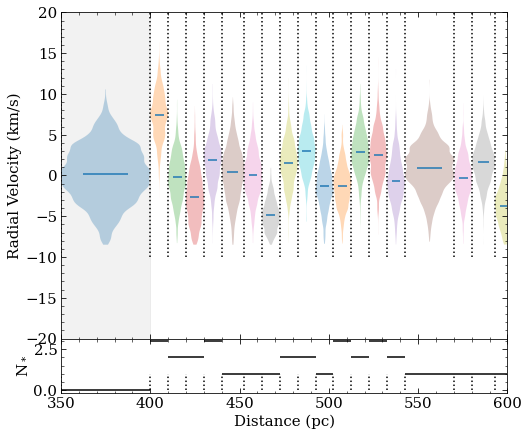

N  1


IndexError: list index out of range

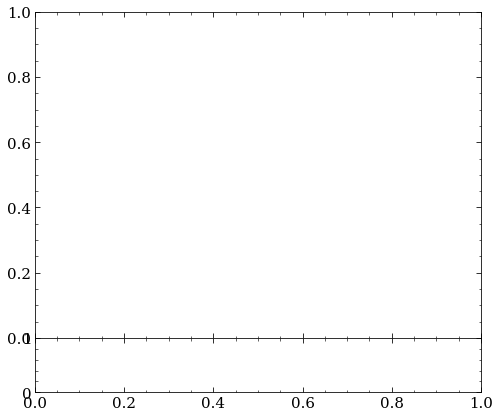

In [69]:
avs = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    avs[i] = np.sum(sl_i.voxel_dAVdd)

line = lambda x, m, b : m * x + b

cnorm = matplotlib.colors.Normalize(np.min(avs), np.max(avs))
cmap = plt.get_cmap('viridis')
mappable = matplotlib.cm.ScalarMappable(norm = cnorm,  cmap = cmap)


sightlines_slopes = np.zeros(len(sightlines))
sightlines_slopes_err = np.zeros(len(sightlines))


dist_xx_sl = np.array([])
velo_yy_sl = np.array([])
std_velo_sl = np.array([])

priorx = np.linspace(-20, 20, 100)

# for i in range(len(sightlines)): 
for i in range(0, len(sightlines)): 

    print('N ', i)
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})

    

    dist_xx = np.array([])
    velo_yy = np.array([])
    std_velo = np.array([])
    sl_i = sightlines[i]
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i)
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(chains[i], sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color, 
                                                        plot_box = False, plot_violin=True, bestprob = False, lnprob = probabilities[i])
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])

    print(dist_xx)
    print(velo_yy)



    dist_sort = np.argsort(dist_xx)
    # print(dist_sort)

    try:
        filt = (dist_xx[dist_sort] > 400) & (dist_xx[dist_sort] <= 800)
        print(dist_xx[dist_sort][filt])
        fit_result = curve_fit(line, dist_xx[dist_sort][filt], velo_yy[dist_sort][filt], sigma = std_velo[dist_sort][filt])
        print(fit_result)
        fit_params = fit_result[0]
        fit_result_err = np.sqrt(np.diag(fit_result[1]))
        xx_plot = np.linspace(380, 600)

        # axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]), label = 'SL ' + str(i))
        sightlines_slopes[i] = fit_params[0] 
        sightlines_slopes_err[i] = fit_result_err[0]
    except Exception as e:
        print('didn\'t fit properly')
        print(e)
        sightlines_slopes[i] = np.nan

    # ### ADDDED 03.28 ###
    # fgprior = prior_for_plot(sl_i.l, sl_i.b, priorx)
    # axs[0].plot(5e2 * fgprior + 350, priorx, color = 'grey', linestyle = 'dashed')

    # ### ADDED 03.31 ###
    # profile, rvel = get_CO_profile(sl_i.l, sl_i.b)
    # axs[0].plot(600- 5e1*profile, rvel)

#     axs[1].plot(dust_data.distance, sl_davdd[i, :], color = 'k')
#     # ax.set_ylim(ymin, ymax)
#     axs[1].set_xlim(350, 600)
#     axs[1].set_xlabel('Distance (pc)')
#     axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
#     axs[1].set_ylim(0, 0.05)
    fig.set_facecolor('white')

    # ylim0 = (-vv[i]* 1.2, +vv[i]*1.2)
    ylim0 = (-20, 20)
    axs[0].set_ylim(*ylim0)
    axs[0].fill_between((350, 400), (ylim0[1], ylim0[1]), (ylim0[0], ylim0[0]), color = 'grey', alpha = 0.1)

    # ylim1 = (-0.001, 0.05)
#     axs[1].set_ylim(*ylim1)
#     axs[1].fill_between((350, 400), (ylim1[1], ylim1[1]), (ylim1[0], ylim1[0]), color = 'grey', alpha = 0.1)

    # for j in range(len(sl_i.stars)):
    #     axs[1].scatter(sl_i.stars['DIST'][j], sl_davdd[i, find_nearest_dist(sl_i.stars['DIST'][j])])

    # axs[0].legend()
    # name_i = 'veldist_' + str(i)
#     fig.savefig('RUNS_H5/figures_0602a/0602a_VelModels/velo_plot_{}.png'.format(i) )


    # vrange, scale = vv[i], 0
    # rvelo, star_loc_rvelo_scattered, star_locs = velo_profile(vrange, scale = scale)
    # axs[0].plot(dust_data.distance, rvelo, color = 'r', linestyle = 'dotted')

    # aux_axis = axs[0].aux_axis['0, 1, 1, 0.01']

    axs[1].hlines(np.bincount(sl_i.bin_inds)[1:], sl_i.bins[:-1], sl_i.bins[1:],  color = 'k')
    axs[1].set_xlabel('Distance (pc)')
    axs[1].set_ylabel('N$_*$')

    plt.show()

    dist_xx_sl = np.concatenate([dist_xx_sl, dist_xx])
    velo_yy_sl = np.concatenate([velo_yy_sl, velo_yy])
    std_velo_sl = np.concatenate([std_velo_sl, std_velo])

In [70]:
sightlines[0].bin_inds
# print(sightlines[0].bins)
print(len(np.bincount(sightlines[0].bin_inds)))
print(len(sightlines[0].bins))

21
21


(array([0., 3., 2., 2., 3., 1., 1., 1., 2., 2., 1., 3., 2., 3., 2., 1., 1.,
        1., 1., 1.]),
 array([350.        , 400.01000977, 410.02001953, 420.0300293 ,
        430.04003906, 440.05004883, 452.54376221, 462.55377197,
        472.56378174, 482.5737915 , 492.58380127, 502.59381104,
        512.6038208 , 522.61383057, 532.62384033, 542.6338501 ,
        570.28302002, 580.29302979, 593.00030518, 604.78100586,
        923.43756104]),
 <BarContainer object of 20 artists>)

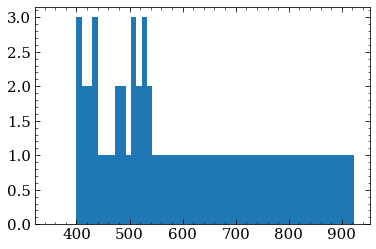

In [71]:
plt.hist(sightlines[0].stars['DIST'], bins = sightlines[0].bins)

In [72]:
# 0517a: 5 sightline run with previous standard priors, etc, likelihood mutiplied by 2
# 0517b: 5 sightline run with previous standard priors, etc, likelihood mutiplied by 4
# 0517c: should be a normal kt run liike 0513a, first 20 sightlines. This should be my baseline, basically
# 0530a: maintains no Gaussian priors on extinction (other than the foreground. 5 sightlines, 1000 steps, 500 walkers


In [73]:
# fig, ax = plt.subplots()
# ax.plot(sightlines[0].sampler.chain[:, :, 0].T, color = 'k', alpha = 0.1)

In [74]:
def polynomial2d( x1, x2, theta = None, uncert = None):  
        if theta is None:
            theta = np.array([5.03964666, -1.04129592, -0.72842925, -0.20292219,  0.0206567,  -0.14442016])
        if uncert is None:
            uncert = 2.404363059339516
        if np.array(x1).ndim != 1:
            x1 = np.array([x1])
            x2 = np.array([x2])
        x1 = x1 - 160 # FOR CA CLOUD SPECIFICIALLY
        x2 = x2 + 8 # DITTO
        X = np.array([[np.ones(np.array(x1).shape), x1, x2, x1 * x2, x1**2, x2**2]]).T
        matrix = X * theta[:, np.newaxis]
        print(matrix.shape)
        return np.nansum(matrix, axis = 1).flatten()

def box(x, min = -8.5, max = 17.5):
     y = np.ones(len(x))
     y[x < min] = 0
     y[x > max] = 0
     return y

def prior_for_plot(l, b, x ):
    gaussn = lambda x, mu, sig : 1/(np.sqrt(2 * np.pi) * sig) * np.exp(-(x - mu)**2 / (2* sig**2))     
    # x = np.linspace(-20, 20, 100)
    sig =  2.404363059339516
    mu = polynomial2d(l, b)
    print(mu)
    return gaussn(x, mu, sig) #* box(x)

priorx = np.linspace(-20, 20, 100)

In [75]:
def make_corner(sampler, labels, minval = 50):
    dim = sampler.chain.shape[-1]
    samples = sampler.chain[:, minval:, :].reshape((-1, dim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

def make_corner_vonly(sampler, ndim, labels, minval = -100):
    samples = sampler.chain[:, minval:, :ndim].reshape((-1, ndim))
    print(samples.shape)
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    return fig
    plt.show()

if False:
    for i in range(0, len(sightlines)):
        sl_i = sightlines[i]
        ndim = len(sl_i.bins) - 1 
        fig = make_corner_vonly(sl_i.sampler, ndim, labels = None, minval =-200)
        axes = np.array(fig.axes).reshape(ndim, ndim)
        axes[0, 0].plot(priorx, 1e5* prior_for_plot(sl_i.l, sl_i.b, priorx))
        plt.show()

N 0
ndim 20
nstars 33
medians shape (680,)
med_velo shape (20,)
med_dAV_dd shape (33, 20)
order_inds [ 5 14 29 28 17 31 25 20  2 18 12  9  4 21  0 16 26 11 15 22 27  8  6  3
  7 19 10 23 24 30 32  1 13]
signal_recreated.shape (33, 95)
5
14
29
28
17
31
25
20
2
18
12
9
4
21
0
16
26
11
15
22
27
8
6
3
7
19
10
23
24
30
32
1
13


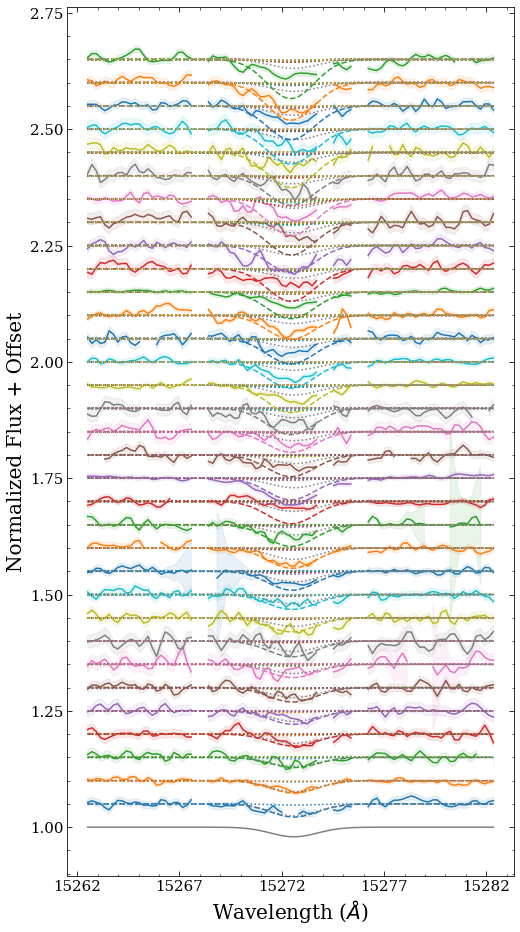

N 1


AttributeError: 'ForegroundModifiedSightline' object has no attribute 'sampler'

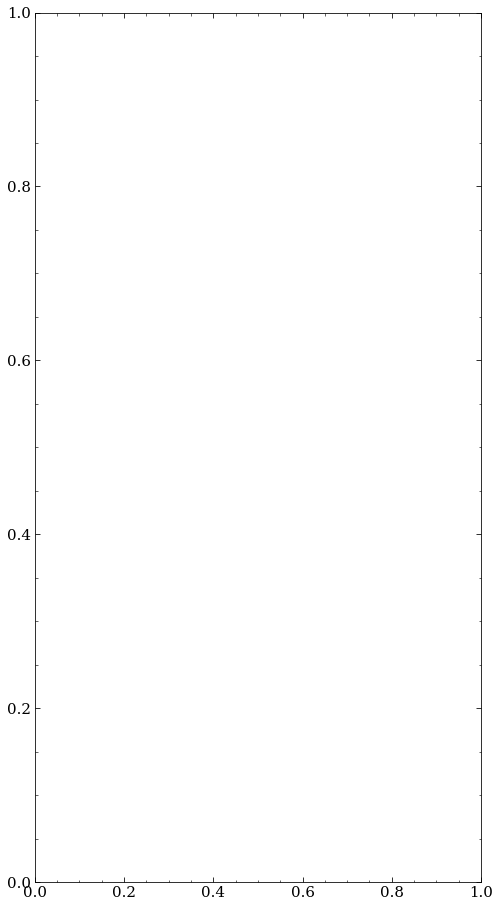

In [76]:
def model_signals_fg(rvelo, sl, dAVdd):
    # dAVdd = sl.dAVdd
    voxeldiffDIB = np.zeros((len(sl.stars), len(wavs_window)))
    unsummed_signals = np.zeros((len(sl.stars), len(sl.bins)-1,len(wavs_window)))
    # unsummed_signals = np.zeros((len(sl.bins)-1, len(sl.bins)-1,len(wavs_window)))

#     print(voxeldiffDIB.shape, unsummed_signals.shape, sl.dAVdd.shape)
    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(sl.bins) - 1, 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
    amp = differentialAmplitude(dAVdd, sl.bins[1:]-sl.bins[:-1])

    def single_signal(amp, bindex):

        amp[bindex:] = 0 # THIS MIGHT NEED TO BE -1
        # print(amp)

        voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        # continuum = lambda x, m, b : m * (x - lambda0) + b
        # cont = continuum(wavs_window, 0, b)
        return summed_DIB  + 1, voxel_DIB_scaled 

    fgdiffDIB = np.zeros((len(sl.stars), len(wavs_window)))
    

    for i in range(len(sl.stars)): # Iterate over each star in dAVdd array
#         print(dAVdd)
        dAVdd_bin = dAVdd[i, :] 

        amp = differentialAmplitude(dAVdd_bin, 1)

        bin_index = np.concatenate([sl.bin_inds]).astype(int)[i] # this only goes to 
        # signals[i, :] = single_signal(bin_index)
        voxeldiffDIB[i, :], unsummed_signals[i, :, :] = single_signal(amp, bin_index)
        fgdiffDIB[i, :], _ = single_signal(amp, 1)


    return voxeldiffDIB, unsummed_signals, fgdiffDIB

def plot_DIBS_fg(sampler, sl, plot_objs = None, bestprob = False):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs

    ndim = len(sl.voxel_dAVdd)
    print('ndim', ndim)
    nstars = len(sl.stars)
    print('nstars', nstars)

    samples = sampler.chain[:, :, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[-100:, :], axis = 0)
    print('medians shape', medians.shape)

    ## NEW THING
    if bestprob:
        lp = sl.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
#     print(med_dAV_dd)
    print('med_velo shape', med_velo.shape)
    print('med_dAV_dd shape', med_dAV_dd.shape)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # order_inds = (np.array(np.argsort(sl.stars['DIST'])))
    print('order_inds', order_inds)

    signal_recreated, signal_recreated_unsummed, fg_dibs = model_signals_fg(med_velo, sl, med_dAV_dd) 

    print('signal_recreated.shape', signal_recreated.shape)


    ax.plot(wavs[window], fg_dibs[0, :], linestyle = 'solid', color ='grey')

    for i in range(len(order_inds)):
        ii = order_inds[i]
        print(ii)
        offset_i = i+1

        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])

        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * offset_i, color = 'C{}'.format(i))
        ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * offset_i,
                         sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * offset_i, color = 'C{}'.format(i), alpha = 0.1)

        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * offset_i , color = 'C{}'.format(i), linestyle = 'dashed',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            if j==0:
                col = 'grey'
            else:
                col = 'C{}'.format(j-1)
            if j > i+1:
                continue
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1  + 0.05 * offset_i, color=col, linestyle = 'dotted', alpha = 1)

    # ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux + Offset', fontsize = 20)
    fig.set_facecolor('white')

    # ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_xticks(np.linspace(15272-10, 15272 + 10, 5))

    # ax.set_yticklabels('')

    return signal_recreated, sl.signals, sl.signal_errs

chi2s = np.zeros(len(sightlines))
sl_lensignals = np.zeros(len(sightlines))

recreated_signals = []

for i in range(len(sightlines)):
    print('N', i)
    fig, ax = plt.subplots(figsize = (8, 16))

    sl_i = sightlines[i]
    sl_lensignals[i] = sl_i.nsig
    sampler_i = sl_i.sampler
    reproducedDIBs, realDIBs, realDIBerrs = plot_DIBS_fg(sampler_i, sl_i, plot_objs = (fig, ax))

    chi2 = np.nansum((realDIBs-reproducedDIBs)**2 / realDIBerrs**2) / np.sum(np.isnan(realDIBs) == False)
    chi2s[i] = chi2

    # ymin, ymax = ax.get_ylim()
    # ax.text(lambda0, ymax - .01, str(chi2))

    lp_i = sampler_i.lnprobability
    lp_med_i = np.nanmedian(lp_i[:, -100:])
    # ax.text(lambda0, ymax - .01, 'sl index {}'.format(i) )
    # ax.text(lambda0, ymax - .015, 'lnprob {}'.format(lp_med_i) )

    name_i = 'dibs_' + str(i)
    # fig.savefig('RUNS_H5/figures_0602a/0602a_DIBmodels/model_sl{}.png'.format(name_i))

    plt.show()

    ### Added 05.13 ###
    recreated_signals.append(reproducedDIBs)


In [41]:
sl_davdd = np.zeros((len(l_sample.flatten()), dust_data.dustmap.shape[-1]))
for i in range(len(l_sample.flatten())): 
    l_i, b_i = l_sample.flatten()[i], b_sample.flatten()[i]
    l_ind, b_ind = find_nearest(l_i, b_i)
    sl_davdd[i, :] = np.copy(dust_data.dustmap[b_ind, l_ind, :])


In [ ]:
for i in range(len(sightlines)):
    sl = sightlines[i]
    recreated_signals_i = recreated_signals[i]

    chi2_per_signal = np.nansum((sl.signals - recreated_signals_i)**2 / recreated_signals_i, axis = 1)
    print(chi2_per_signal)

[0.00633039 0.00587142 0.01734767 0.00731205 0.00364255 0.01303731
 0.01051663 0.00212814 0.03175559 0.00148582 0.00641253 0.00810363
 0.00492264 0.00504197 0.02776536 0.01427091 0.01258395 0.00476562
 0.01716261 0.02467803 0.01265216 0.01176059 0.01182478 0.00483308
 0.00427156]


[1.65196978]


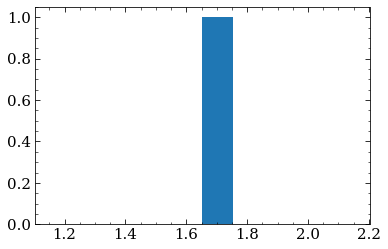

In [ ]:
fig, ax = plt.subplots()
ax.hist(chi2s)
print(chi2s)

In [44]:
def plot_velo(sampler, sl , min_walker = None, plot_objs = None, color = None, plot_lines = False, plot_box = False, plot_violin = False, bestprob = False,):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    ndim = len(sl.voxel_dAVdd)

    walker_max = sampler.chain.shape[1]

    if min_walker is None:
        min_walker_val = -100
    # else:
    min_walker_val = walker_max - min_walker

    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))

    vel_samples = samples[:, :sl.ndim]
    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))

    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    if bestprob:
        lp = sl_i.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]


    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    perc16, perc50,  perc84 = (np.percentile(samples[min_walker_val:, :], 16, axis = 0), 
                               np.percentile(samples[min_walker_val:, :], 50, axis = 0),
                               np.percentile(samples[min_walker_val:, :], 84, axis = 0) )
    velo16, velo50, velo84 = (perc16[:ndim], perc50[:ndim], perc84[:ndim])

    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)


    # ax.scatter((a.bins[1:] + a.bins[:-1] ) /2 , med_velo)
    # if
    # for i in range(len(sl.bins)-1): 
    #     ax.hlines(med_velo[i], sl.bins[i], sl.bins[i+1], linestyle = 'dashed')
    #     if i < len(sl.bins) -2:
    #         ax.vlines(sl.bins[i+1], med_velo[i], med_velo[i+1], linestyle = 'dashed')

    if color == None:
        color_choice = 'k'
    else:
        color_choice = color
    

    if plot_box:
        # ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'dashed', linewidth = 0.5)
        # ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = color_choice)
        ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = 'k')


        for j in range(len(sl.bins)-1):
            # ax.fill_between([sl.bins[i], sl.bins[i +1]], med_velo[i]+std_velo[i], med_velo[i]-std_velo[i], 
            #                 alpha = 0.3, color = color_choice, hatch = '/')
            ax.fill_between([sl.bins[j], sl.bins[j +1]], velo84[j], velo16[j], 
                    alpha = 0.3, color = 'C{}'.format(j))

    axmin = 350
    if plot_violin:
        colorlist = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
        bin_pos = sl.bins[:]
        bin_pos[0] = axmin
        pos = (bin_pos[1:] + bin_pos[:-1])/2
        
        w = (bin_pos[1:] - bin_pos[:-1])
        vparts=ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=True, side = 'both')
        for vindx, part in enumerate(vparts['bodies']):
            part.set_facecolor(colorlist[vindx])
            
        plot_guides = True
        if plot_guides:
            for pos in bin_pos:
                ax.plot((pos, pos), (-10, 20), color = 'k', linestyle = 'dotted')
                axs[1].plot((pos, pos), (0, 1), color = 'k', linestyle = 'dotted')
    
    plot_violin_half = False
    if plot_violin_half:
        colorlist = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
        bin_pos = sl.bins[:]
        bin_pos[0] = axmin
        pos =  bin_pos[1:]
        
        w = np.min(2* (bin_pos[1:] - bin_pos[:-1]))
        vparts=ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=True, side = 'low')
        for vindx, part in enumerate(vparts['bodies']):
            part.set_facecolor(colorlist[vindx])


    # else:  
    #     # ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    #     # ax.scatter((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, c = color_choice)
    #     ax.errorbar((sl.bins[1:] ) , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    #     ax.scatter((sl.bins[1:] ) , med_velo, c = color_choice)
    #     if plot_lines:
    #         ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'solid', linewidth = .5)



    # ax.errorbar((sl.bins[1:]),med_velo, xerr = (sl.bins[1:] - sl.bins[:-1], np.zeros(med_velo.shape)), yerr = std_velo, fmt = '.' )
    ax.set_xlim(axmin, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo


def plot_velo_nodist(sampler, sl , min_walker = None, plot_objs = None, color = None, plot_lines = False, plot_box = False, plot_violin = False, bestprob = False,):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    ndim = len(sl.voxel_dAVdd)

    walker_max = sampler.chain.shape[1]

    if min_walker is None:
        min_walker_val = -100
    # else:
    min_walker_val = walker_max - min_walker

    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))

    vel_samples = samples[:, :sl.ndim]
    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))

    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    if bestprob:
        lp = sl_i.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]


    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    perc16, perc50,  perc84 = (np.percentile(samples[min_walker_val:, :], 16, axis = 0), 
                               np.percentile(samples[min_walker_val:, :], 50, axis = 0),
                               np.percentile(samples[min_walker_val:, :], 84, axis = 0) )
    velo16, velo50, velo84 = (perc16[:ndim], perc50[:ndim], perc84[:ndim])

    if color == None:
        color_choice = 'k'
    else:
        color_choice = color

    axmin = 350
    if plot_violin:
        colorlist = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
        bin_pos = sl.bins[:]
        print(bin_pos)
        # bin_pos[0] = axmin

        # items = len()
        pos = (bin_pos[1:] + bin_pos[:-1])/2
        
        w = (bin_pos[1:] - bin_pos[:-1])

        pos = np.linspace(0,1, len(sl.bins)-1)
        w = pos[1] - pos[0]
        pos = pos + w/2


        ax.set_xticks(np.concatenate([[0], pos -w/2]))
        ax.set_xticklabels(bin_pos)

        vparts=ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=True, side = 'both')
        for vindx, part in enumerate(vparts['bodies']):
            part.set_facecolor(colorlist[vindx])
            
        # plot_guides = True
        # if plot_guides:
        #     for pos in bin_pos:
        #         ax.plot((pos, pos), (-10, 20), color = 'k', linestyle = 'dotted')
        #         # axs[1].plot((pos, pos), (0, 1), color = 'k', linestyle = 'dotted')
    
    plot_violin_half = False
    if plot_violin_half:
        colorlist = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
        bin_pos = sl.bins[:]
        bin_pos[0] = axmin
        pos =  bin_pos[1:]
        
        w = np.min(2* (bin_pos[1:] - bin_pos[:-1]))
        vparts=ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=True, side = 'low')
        for vindx, part in enumerate(vparts['bodies']):
            part.set_facecolor(colorlist[vindx])

    ax.set_xlim(0, 1)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo


In [45]:
if False:
    for i in range(1): 
        sl_i = sightlines[i]
        plot_velo_nodist(sl_i.sampler, sl_i, min_walker = 100, plot_objs = None, color = None, plot_lines = False, plot_box = False, plot_violin = True, bestprob = False)
        plt.show()